In [1]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
'''rawdf = pd.read_csv
df = pd.read_csv('rd4dd_census_clean.csv')'''

trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

X_train = trainset.drop(['OP_time'], axis=1)
X_test = testset.drop(['OP_time'], axis=1)
y_train = trainset['OP_time'].values
y_test = testset['OP_time'].values

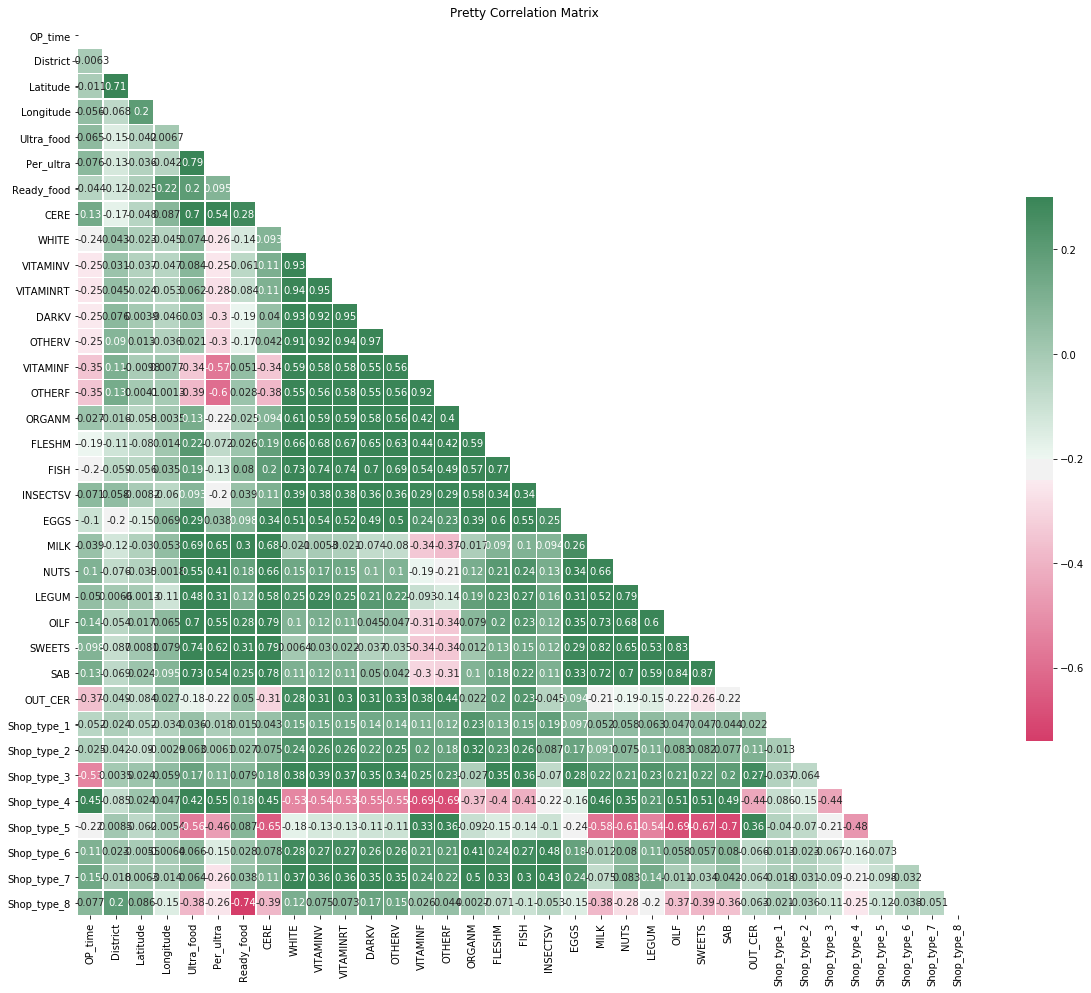

In [3]:
#pretty correlation matrix

df = trainset.append(testset)
coordf = df.copy().corr()
coordf

mask = np.triu(np.ones_like(coordf, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(0, 500, as_cmap=True)
sns.heatmap(coordf, annot=True, mask=mask, cmap=cmap, vmax=.3, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Pretty Correlation Matrix')
plt.show()

In [4]:
top5pos=coordf['OP_time'].sort_values()[:5].to_frame().rename(columns={"OP_time":"Positive Correlations with OP_time"})
top5neg=coordf['OP_time'].sort_values()[-6:-1].to_frame().rename(columns={"OP_time":"Negative Correlations with OP_time"})
display(top5pos,top5neg)

,Positive Correlations with OP_time
Shop_type_3,-0.530725
OUT_CER,-0.366220
OTHERF,-0.353150
VITAMINF,-0.350997
VITAMINRT,-0.254453


,Negative Correlations with OP_time
SAB,0.129101
CERE,0.133925
OILF,0.144419
Shop_type_7,0.146249
Shop_type_4,0.446169


# Testing Models

### MLP Regression Using Top Five Positive Correlations

In [5]:
X_train1 = X_train[['Shop_type_3', 'OUT_CER', 'OTHERF', 'VITAMINF', 'VITAMINRT']]
X_test1 = X_test[['Shop_type_3', 'OUT_CER', 'OTHERF', 'VITAMINF', 'VITAMINRT']]
MLPRTop5p = MLPRegressor(max_iter = 1000,random_state=1).fit(X_train1, y_train)
MLPRTop5p_pred = MLPRTop5p.predict(X_test1)
MLPRTop5p_r2_score=r2_score(y_test, MLPRTop5p_pred)

print('R^2 score against test: %.4f'% MLPRTop5p_r2_score)
coordf2=coordf.rename(columns={"OP_time":"Correlation with OP_Time"})
coordf2['Correlation with OP_Time'].sort_values(ascending=False)[1:6].to_frame()

R^2 score against test: 0.4316


,Correlation with OP_Time
Shop_type_4,0.446169
Shop_type_7,0.146249
OILF,0.144419
CERE,0.133925
SAB,0.129101


### MLP Regression Using Top Five Negative Correlations

In [6]:
X_train2 = X_train[['SAB', 'CERE', 'OILF', 'Shop_type_7', 'Shop_type_4']]
X_test2 = X_test[['SAB', 'CERE', 'OILF', 'Shop_type_7', 'Shop_type_4']]
MLPRTop5n = MLPRegressor(max_iter = 1000,random_state=1).fit(X_train2, y_train)
MLPRTop5n_pred = MLPRTop5n.predict(X_test2)
MLPRTop5n_r2_score=r2_score(y_test, MLPRTop5n_pred)

print('R^2 score against test: %.4f'% MLPRTop5n_r2_score)
coordf2=coordf.rename(columns={"OP_time":"Correlation with OP_Time"})
coordf2['Correlation with OP_Time'].sort_values()[1:6].to_frame()

R^2 score against test: 0.4245


,Correlation with OP_Time
OUT_CER,-0.366220
OTHERF,-0.353150
VITAMINF,-0.350997
VITAMINRT,-0.254453
VITAMINV,-0.249269


### MLP Regression Using Five Features from RFE

In [7]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
features = list(X_train.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()
#pd.DataFrame(selection, columns=['Features']).style.hide_ind

X_train3 = X_train[selection]
X_test3 = X_test[selection]
MLPR5 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train3, y_train)
MLPR5_pred = MLPR5.predict(X_test3)
MLPR5_r2_score = r2_score(y_test, MLPR5_pred)

print('R^2 score against test: %.4f'% MLPR5_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.4939
Features used: MILK Shop_type_3 Shop_type_5 Shop_type_6 Shop_type_7


### MLP Regression Using Ten Features from RFE


In [8]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)
features = list(X_train.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train4 = X_train[selection]
X_test4 = X_test[selection]
MLPR10 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train4, y_train)
MLPR10_pred = MLPR10.predict(X_test4)
MLPR10_r2_score = r2_score(y_test, MLPR10_pred)

print('R^2 score against test: %.4f'% MLPR10_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.4364
Features used: CERE OTHERF MILK NUTS Shop_type_1 Shop_type_3 Shop_type_5 Shop_type_6 Shop_type_7 Shop_type_8


### MLP Regression Using Fifteen Features from RFE

In [9]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(X_train, y_train)
features = list(X_train.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train5 = X_train[selection]
X_test5 = X_test[selection]
MLPR15 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train5, y_train)
MLPR15_pred = MLPR15.predict(X_test5)
MLPR15_r2_score = r2_score(y_test, MLPR15_pred)

print('R^2 score against test: %.4f'% MLPR15_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.4513
Features used: CERE OTHERV OTHERF ORGANM FLESHM MILK NUTS OILF Shop_type_1 Shop_type_3 Shop_type_4 Shop_type_5 Shop_type_6 Shop_type_7 Shop_type_8


### MLP Regression Using Twenty Features from RFE

In [10]:
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(X_train, y_train)
features = list(X_train.columns)
selection = pd.Series(selector.support_,index = features)
selection = selection[selection==True].index.to_list()

X_train6 = X_train[selection]
X_test6 = X_test[selection]
MLPR20 = MLPRegressor(max_iter = 10000,random_state=1).fit(X_train6, y_train)
MLPR20_pred = MLPR20.predict(X_test6)
MLPR20_r2_score = r2_score(y_test, MLPR20_pred)

print('R^2 score against test: %.4f'% MLPR20_r2_score)
print('Features used:',' '.join(selection))

R^2 score against test: 0.4658
Features used: Ultra_food CERE WHITE VITAMINV DARKV OTHERV OTHERF ORGANM FLESHM INSECTSV MILK NUTS OILF Shop_type_1 Shop_type_3 Shop_type_4 Shop_type_5 Shop_type_6 Shop_type_7 Shop_type_8


# Summarize Model Results

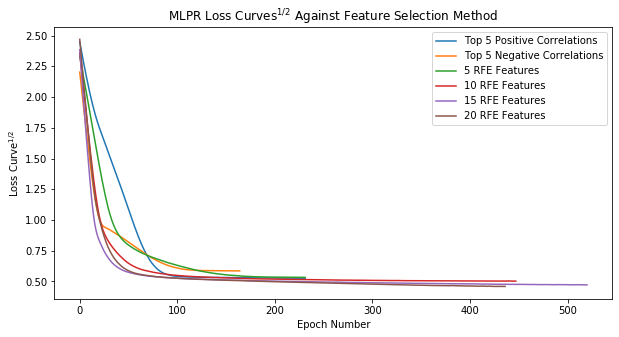

Feature Selection,MSE on Training Set,MSE on Test Set,R$^2$ Score
5 Top Positive Correlations,0.553752,0.476973,0.431638
5 Top Negative Correlations,0.686082,0.482975,0.424486
5 RFE Features,0.567764,0.424711,0.493913
10 RFE Features,0.504286,0.472952,0.436429
15 RFE Features,0.444516,0.460482,0.451289
20 RFE Features,0.421104,0.448324,0.465776


In [11]:
plt.figure(figsize=(10,5))

plt.plot(np.sqrt(MLPRTop5p.loss_curve_),label='Top 5 Positive Correlations')
plt.plot(np.sqrt(MLPRTop5n.loss_curve_),label='Top 5 Negative Correlations')
plt.plot(np.sqrt(MLPR5.loss_curve_),label='5 RFE Features')
plt.plot(np.sqrt(MLPR10.loss_curve_),label='10 RFE Features')
plt.plot(np.sqrt(MLPR15.loss_curve_),label='15 RFE Features')
plt.plot(np.sqrt(MLPR20.loss_curve_),label='20 RFE Features')

plt.title('MLPR Loss Curves$^{1/2}$ Against Feature Selection Method')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Curve$^{1/2}$')
plt.legend(loc='best')
plt.show()

MLPRTop5p_train_pred = MLPRTop5p.predict(X_train1)
MLPRTop5n_train_pred = MLPRTop5n.predict(X_train2)
MLPR5_train_pred = MLPR5.predict(X_train3)
MLPR10_train_pred = MLPR10.predict(X_train4)
MLPR15_train_pred = MLPR15.predict(X_train5)
MLPR20_train_pred = MLPR20.predict(X_train6)

MLPRTop5p_test_pred = MLPRTop5p.predict(X_test1)
MLPRTop5n_test_pred = MLPRTop5n.predict(X_test2)
MLPR5_test_pred = MLPR5.predict(X_test3)
MLPR10_test_pred = MLPR10.predict(X_test4)
MLPR15_test_pred = MLPR15.predict(X_test5)
MLPR20_test_pred = MLPR20.predict(X_test6)

summarydata = [['5 Top Positive Correlations',mean_squared_error(y_train, MLPRTop5p_train_pred),
             mean_squared_error(y_test, MLPRTop5p_test_pred),MLPRTop5p_r2_score],
            ['5 Top Negative Correlations',mean_squared_error(y_train, MLPRTop5n_train_pred),
             mean_squared_error(y_test, MLPRTop5n_test_pred),MLPRTop5n_r2_score],
            ['5 RFE Features',mean_squared_error(y_train, MLPR5_train_pred),
             mean_squared_error(y_test, MLPR5_test_pred),MLPR5_r2_score],
            ['10 RFE Features',mean_squared_error(y_train, MLPR10_train_pred),
             mean_squared_error(y_test, MLPR10_test_pred),MLPR10_r2_score],
            ['15 RFE Features',mean_squared_error(y_train, MLPR15_train_pred),
             mean_squared_error(y_test, MLPR15_test_pred),MLPR15_r2_score],
            ['20 RFE Features',mean_squared_error(y_train, MLPR20_train_pred),
             mean_squared_error(y_test, MLPR20_test_pred),MLPR20_r2_score]]

df=pd.DataFrame(summarydata, columns=['Feature Selection','MSE on Training Set','MSE on Test Set','R$^2$ Score'])#.style.hide_index()
#df.style.apply(custom_style, axis=1)
color = (df['Feature Selection'] == '5 RFE Features').map({True: 'background-color: yellow', False: ''})
df.style.apply(lambda s: color).hide_index()

### Huh? Matrix

In [15]:
display(confusion_matrix(y_test,MLPR5_pred.round()))
print('Accuracy score against test: %.2f'%float(100*accuracy_score(y_test,MLPR5_pred.round())),'%')

array([[ 0,  2,  2,  1],
       [ 0,  9,  8,  2],
       [ 0,  1,  7, 10],
       [ 0,  0,  5, 65]])

Accuracy score against test: 72.32 %
